# Scikit Learn Walkthorough

This notebook is a walkthorough of the scikit learn API for XGBoostLSS. It attempts to show how a typical sklearn workflow can be used with XGBoostLSS while still allowing a user to access the additional functionality of XGBoostLSS.

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/StatMixedML/XGBoostLSS/blob/master/docs/examples/Gaussian_Regression.ipynb)

# Imports

First, we import the necessary functions.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt

from xgboostlss.datasets.data_loader import (
    load_simulated_gaussian_data, generate_simulated_gaussian_data
)

from xgboostlss.sklearn import XGBLSSRegressor

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

from scipy.stats.distributions import norm

# Data

Let's define some helper functions and take a look at the dataset.

In [2]:
def neg_log_likelihood(y_true, y_pred, scipy_dist=norm, param_list=["loc", "scale"]):
    """
    Negative Log Likelihood (NLL) scorer for sklearn.

    Uses mean instead of sum to compare train and test sets. For non-gaussian
    distributions, the param_list should be carefully updated to match those
    found in scipy.stats.distributions and ordered as the distributions module.
    """
    dist_param_kwargs = dict(zip(param_list, y_pred.T))
    return -np.mean(scipy_dist.logpdf(y_true, **dist_param_kwargs))


def train_test_scorer_df(
    y_train,
    y_pred_train,
    y_test,
    y_pred_test,
    test_run_name,
    scorers=[neg_log_likelihood],
    score_df=None,
    scorer_kwargs=None,
):
    """Compute scores for train and test sets."""
    score_list = []
    if scorer_kwargs is None:
        scorer_kwargs = {}

    for scorer in scorers:
        scorer_name = scorer.__name__
        train_score = scorer(y_train, y_pred_train, **scorer_kwargs)
        test_score = scorer(y_test, y_pred_test, **scorer_kwargs)

        score_list.append(
            pd.DataFrame(
                {
                    "scorer": scorer_name,
                    "train_score": train_score,
                    "test_score": test_score,
                },
                index=[test_run_name],
            )
        )

    if score_df is None:
        score_df = pd.concat(score_list, axis=0)
    else:
        score_df = pd.concat([score_df] + score_list, axis=0)
    return score_df.drop_duplicates(keep='last')


nll_scorer = make_scorer(neg_log_likelihood, greater_is_better=False)

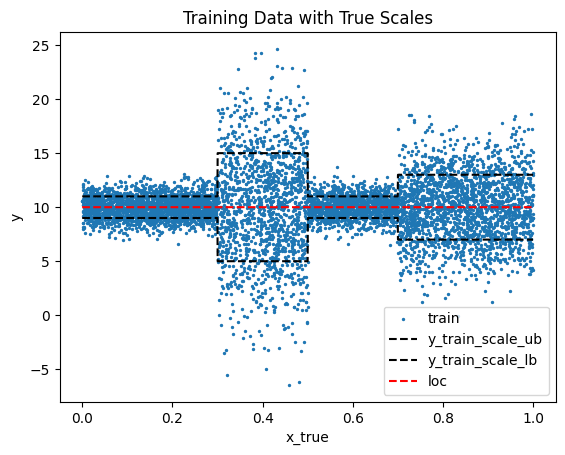

In [3]:
train, test = load_simulated_gaussian_data()

X_train, y_train = train.filter(regex="x"), train["y"]
X_test, y_test = test.filter(regex="x"), test["y"]

X_train_sorted = X_train.sort_values("x_true")
X_test_sorted = X_test.sort_values("x_true")

y_train_scale = generate_simulated_gaussian_data(X_train_sorted)
y_test_scale = generate_simulated_gaussian_data(X_test_sorted)

y_train_true = pd.DataFrame(data={"loc":10, "scale": generate_simulated_gaussian_data(X_train)})
y_test_true = pd.DataFrame(data={"loc":10, "scale": generate_simulated_gaussian_data(X_test)})

X_train_plot_df = (
    X_train_sorted
    .assign(
        y_train_scale_ub=10 + y_train_scale,
        y_train_scale_lb=10 - y_train_scale,
    )
    .set_index("x_true")
)

X_test_plot_df = (
    X_test_sorted
    .assign(
        y_test_scale_ub=10 + y_test_scale,
        y_test_scale_lb=10 - y_test_scale,
    )
    .set_index("x_true")
)

ax = train.plot.scatter(x="x_true", y="y", label="train", color="C0", s=2)
ax.set_title("Training Data with True Scales")
X_train_plot_df.filter(like="scale").assign(loc=10).plot(
    ax=ax, linestyle="--", color=["k", "k", "r"]
)

plt.legend()

Let's take a benchmark score from the known distribution and compare with our test set.

Here the loc parameter is plotted, but will be excluded in future plots as it is constant and of little interest.

,scorer,train_score,test_score
Original Params,neg_log_likelihood,2.07076,2.082057


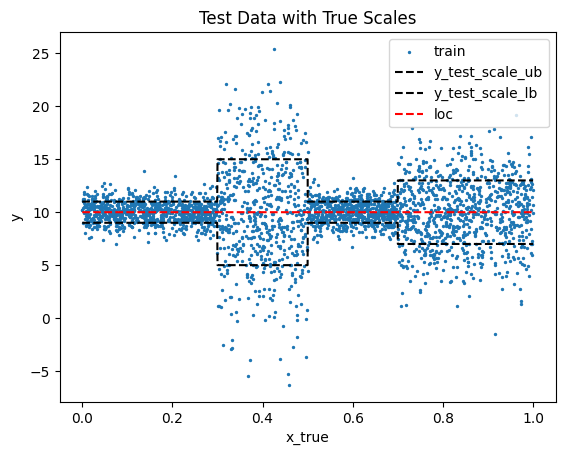

In [4]:
nll_score_df = train_test_scorer_df(
    y_train.values, y_train_true.values, y_test.values, y_test_true.values, "Original Params"
)

ax = test.plot.scatter(x="x_true", y="y", label="train", color="C0", s=2)
X_test_plot_df.filter(like="scale").assign(loc=10).plot(ax=ax, linestyle="--", color=["k", "k", "r"])

ax.set_title("Test Data with True Scales")

nll_score_df

# Model Parameters and Defaults

For XGBoostLSS models, the most important parameter is the distribution. To make getting started with the scikit-learn API as easy as possible, the `XGBLSSRegressor` defaults to a using the `Gaussian` distribution. This is somewhat similar to [GaussianProcessRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.GaussianProcessRegressor.html) in scikit-learn, which default to using `Constant` and an `RBF` kernels in the simplest case.

It should be noted that the distribution choice dictates loss/objective function. Both these terms will be used interchangeably as XGBoost uses the term `objective` and scikit-learn uses the term `loss`. Where possible, `XGBLSSRegressor` will use the scikit-learn terminology.

Other than the `distribution` and lack of the `loss` parameters, all standard [Sklearn XGBoost](https://xgboost.readthedocs.io/en/stable/python/python_api.html#module-xgboost.sklearn) parameters should be usable.

Let's have a play with some of the more familiar parameters. Remember, if unspecified, this defaults to a Gaussian distribution.

,scorer,train_score,test_score
Original Params,neg_log_likelihood,2.070760,2.082057
Hand Tuned,neg_log_likelihood,2.111516,2.143074


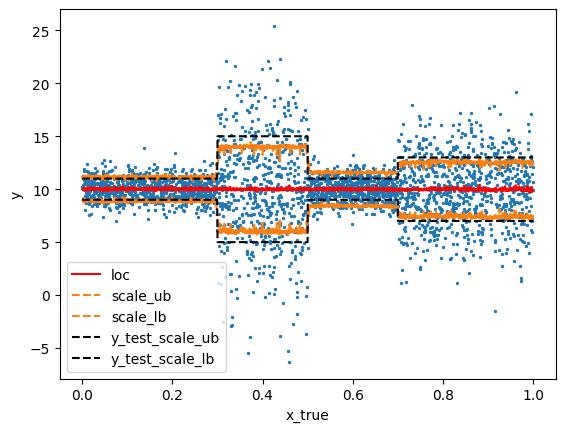

In [5]:
xgblss = XGBLSSRegressor(
    max_depth=2,
    learning_rate=0.05,
    n_estimators=50,
    subsample=0.7,
    colsample_bytree=0.7,
)

xgblss.fit(X_train, y_train)
y_pred_train = xgblss.predict(X_train)
y_pred_test = xgblss.predict(X_test)

test_pred_df = (
    X_test
    .assign(loc=y_pred_test[:, 0], scale=y_pred_test[:, 1])
    .assign(y=y_test)
    .sort_values("x_true")
    .assign(
        scale_ub=lambda df: df["loc"] + df["scale"],
        scale_lb=lambda df: df["loc"] - df["scale"],
    )
)

ax = test_pred_df.plot.scatter(x="x_true", y="y", s=2)
test_pred_df.plot(x="x_true", y='loc', ax=ax, c='r')
test_pred_df.plot(
    x="x_true",
    y=['scale_ub', 'scale_lb'],
    ax=ax,
    style='--',
    color='C1',
)

X_test_plot_df.filter(like="scale").plot(ax=ax, linestyle="--", c="k")

(
    neg_log_likelihood(y_train, y_train_true.values),
    neg_log_likelihood(y_train, y_pred_train),
    neg_log_likelihood(y_test, y_test_true.values),
    neg_log_likelihood(y_test, y_pred_test),
)

nll_score_df = train_test_scorer_df(y_train, y_pred_train, y_test, y_pred_test, "Hand Tuned", score_df=nll_score_df)
nll_score_df

## More Sklearn Machinery

Amazing! We have our first scikit learn XGBoostLSS model. Now we can go one to tune the hyperparameters using standard sklearn machinery. Here is a rough and ready example using grid search.

In [6]:
param_grid = {
    "learning_rate": np.logspace(-1, -3, 4),
    "max_depth": np.array(range(2, 8, 4)),
    "n_estimators": np.logspace(1, 2.7, 4).round(0).astype(int),
}

gscv = GridSearchCV(
    xgblss,
    param_grid=param_grid,
    cv=3,
    scoring=nll_scorer,
)

gscv.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=XGBLSSRegressor(base_score=0, booster=None,
                                       callbacks=None, colsample_bylevel=None,
                                       colsample_bynode=None,
                                       colsample_bytree=0.7, device=None,
                                       dist=<xgboostlss.distributions.Gaussian.Gaussian object at 0x2943c6830>,
                                       early_stopping_rounds=None,
                                       enable_categorical=False,
                                       eval_metric=None, feature_types=None,
                                       gamma=None, grow_policy=None,
                                       im...
                                       max_delta_step=None, max_depth=2,
                                       max_leaves=None, min_child_weight=None,
                                       missing=nan, monotone_constraints=None,
                                       multi_strategy=None, n_estimators=50,
                                       n_jobs=None, num_parallel_tree=None, ...),
             param_grid={'learning_rate': array([0.1       , 0.02154435, 0.00464159, 0.001     ]),
                         'max_depth': array([2, 6]),
                         'n_estimators': array([ 10,  37, 136, 501])},
             scoring=make_scorer(neg_log_likelihood, greater_is_better=False))

,scorer,train_score,test_score
Original Params,neg_log_likelihood,2.070760,2.082057
Hand Tuned,neg_log_likelihood,2.111516,2.143074
Grid Search,neg_log_likelihood,2.033965,2.099166


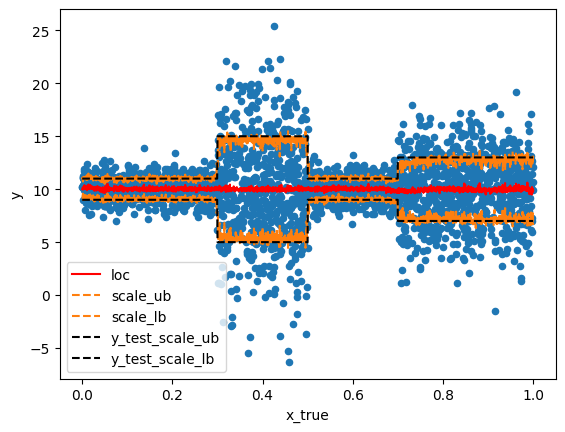

In [7]:
xgblss_best_est = gscv.best_estimator_
y_pred_train = xgblss_best_est.predict(X_train)
y_pred_test = xgblss_best_est.predict(X_test)

test_pred_df = (
    X_test
    .assign(loc=y_pred_test[:, 0], scale=y_pred_test[:, 1])
    .assign(y=y_test)
    .sort_values("x_true")
    .assign(
        scale_ub=lambda df: df["loc"] + df["scale"],
        scale_lb=lambda df: df["loc"] - df["scale"],
    )
)

ax = test_pred_df.plot.scatter(x="x_true", y="y")
test_pred_df.plot(x="x_true", y='loc', ax=ax, color='r')

test_pred_df.plot(
    x="x_true",
    y=['scale_ub', 'scale_lb'],
    ax=ax,
    style='--',
    color='C1',
)

X_test_plot_df.filter(like="scale").plot(ax=ax, linestyle="--", c="k")

nll_score_df = train_test_scorer_df(y_train, y_pred_train, y_test, y_pred_test, "Grid Search", score_df=nll_score_df)
nll_score_df

## Optuna

The grid searchhas given us something of an improvement, however, it is rather clunky and looks to be overfitting. XGBoostLSS comes with hyperparameter optimisation built on top of [optuna](https://optuna.org/). This is a much more efficient way of searching the hyperparameter space. We can however, use the sklearn API with optuna to stay in the sklearn ecosystem.

In [8]:
from optuna import logging
from optuna.distributions import FloatDistribution, IntDistribution
from optuna.integration import OptunaSearchCV


logging.set_verbosity(logging.WARNING)


param_dict = {
    "learning_rate": FloatDistribution(low=1e-5, high=1, log=True),
    "n_estimators": IntDistribution(low=10, high=500),
    "max_depth": IntDistribution(low=1, high=10),
    "gamma": FloatDistribution(low=1e-8, high=40, log=True),
    "subsample": FloatDistribution(low=0.2, high=1.0, log=False),
    "colsample_bytree": FloatDistribution(low=0.2, high=1.0, log=False),
    "min_child_weight": FloatDistribution(low=1e-8, high=500, log=True),
}

oscv = OptunaSearchCV(
    xgblss,
    param_dict,
    timeout=60,
    n_trials=100,
    scoring=nll_scorer,
    cv=3,
    verbose=-1,
)

oscv.fit(X_train, y_train)

/var/folders/3_/hpdpjt6j0f731cvcrx_9h18w0000gr/T/ipykernel_43974/39289325.py:19: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  oscv = OptunaSearchCV(
/Users/Josh.Dunn/mambaforge/envs/xgblss/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/Josh.Dunn/mambaforge/envs/xgblss/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 810, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/Josh.Dunn/mambaforge/envs/xgblss/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/Josh.Dunn/mambaforge/envs/xgblss/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 

OptunaSearchCV(cv=3,
               estimator=XGBLSSRegressor(base_score=0, booster=None,
                                         callbacks=None, colsample_bylevel=None,
                                         colsample_bynode=None,
                                         colsample_bytree=0.7, device=None,
                                         dist=<xgboostlss.distributions.Gaussian.Gaussian object at 0x2943c6830>,
                                         early_stopping_rounds=None,
                                         enable_categorical=False,
                                         eval_metric=None, feature_types=None,
                                         gamma=None, grow_policy=None,...
                                    'max_depth': IntDistribution(high=10, log=False, low=1, step=1),
                                    'min_child_weight': FloatDistribution(high=500.0, log=True, low=1e-08, step=None),
                                    'n_estimators': IntDistribution(high=500, log=False, low=10, step=1),
                                    'subsample': FloatDistribution(high=1.0, log=False, low=0.2, step=None)},
               scoring=make_scorer(neg_log_likelihood, greater_is_better=False),
               timeout=60, verbose=-1)

,scorer,train_score,test_score
Original Params,neg_log_likelihood,2.070760,2.082057
Hand Tuned,neg_log_likelihood,2.111516,2.143074
Grid Search,neg_log_likelihood,2.033965,2.099166
Optuna,neg_log_likelihood,2.066795,2.095923


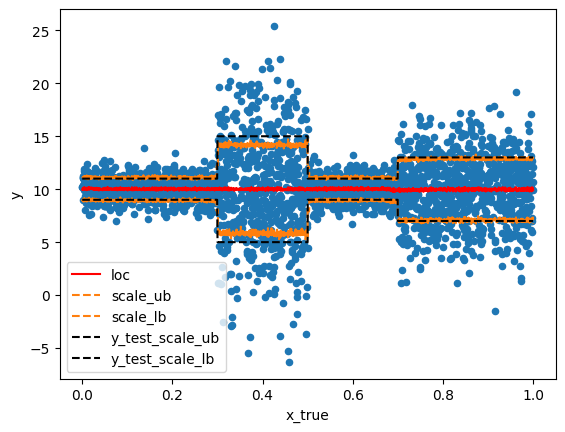

In [9]:
xgblss_best_est = oscv.best_estimator_
y_pred_train = xgblss_best_est.predict(X_train)
y_pred_test = xgblss_best_est.predict(X_test)

test_pred_df = (
    X_test
    .assign(loc=y_pred_test[:, 0], scale=y_pred_test[:, 1])
    .assign(y=y_test)
    .sort_values("x_true")
    .assign(
        scale_ub=lambda df: df["loc"] + df["scale"],
        scale_lb=lambda df: df["loc"] - df["scale"],
    )
)

ax = test_pred_df.plot.scatter(x="x_true", y="y")
test_pred_df.plot(x="x_true", y='loc', ax=ax, color='red')
test_pred_df.plot(
    x="x_true",
    y=['scale_ub', 'scale_lb'],
    ax=ax,
    style=['--', '--'],
    color="C1",
)

X_test_plot_df.filter(like="scale").plot(ax=ax, linestyle="--", c="k")

nll_score_df = train_test_scorer_df(y_train, y_pred_train, y_test, y_pred_test, "Optuna", score_df=nll_score_df)
nll_score_df

# Prediction

Similar to a XGBoost model, we now predict from the trained model. Different options are available:

- `samples`: draws `n_samples` from the predicted distribution.
- `quantiles`: calculates quantiles from the predicted distribution.
- `parameters`: returns predicted distributional parameters.

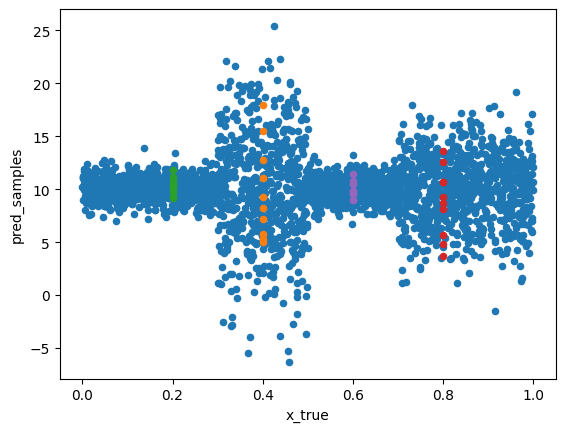

In [10]:
n_samples = 10
X_sample = np.hstack(
    [np.array([0.2, 0.4, 0.6, 0.8]).reshape(-1, 1), X_test.iloc[:4, 1:].values]
)

pred_samples = xgblss_best_est.predict(
    X_sample,
    pred_type="samples",
    n_samples=n_samples,
    validate_features=False,
)

samples_plot_df = (
    pd.DataFrame(pred_samples, index=X_sample[:, 0])
    .rename_axis(index="x_true", columns="sample_n")
    .unstack()
    .to_frame("pred_samples")
)

ax = test_pred_df.plot.scatter(x="x_true", y="y")

for c, df in zip(["C2", "C1", "C4", "C3"], samples_plot_df.groupby("x_true")):
    df[1].reset_index().plot.scatter(x="x_true", y="pred_samples", color=c, ax=ax)

# Plot of Actual vs. Predicted Quantiles

In the following, we plot the predicted quantiles (solid) and compare them to the actual quantiles (dashed).

,scorer,test_score
Optuna Actual 0.05,mean_pinball_loss,0.464580
Optuna Predicted 0.05,mean_pinball_loss,0.447573
Optuna Actual 0.95,mean_pinball_loss,0.459131
Optuna Predicted 0.95,mean_pinball_loss,0.438153


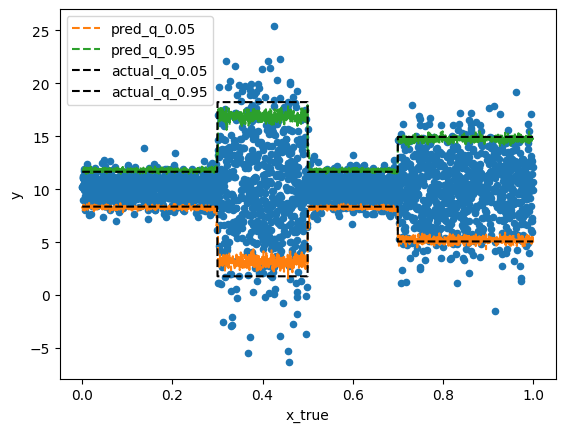

In [11]:
np.random.seed(123)

quantiles = [0.05, 0.95]

# Predict Quantiles
pred_quantiles = xgblss_best_est.predict(
    X_test,
    pred_type="quantiles",
    quantiles=quantiles,
)

pred_quantiles_df = pd.DataFrame(
    pred_quantiles,
    columns=[f"pred_q_{q}" for q in quantiles],
    index=X_test.x_true,
)

# Actual Quantiles
actual_quantiles = np.array([
    norm.ppf(q, loc=10, scale=generate_simulated_gaussian_data(X_test))
    for q in quantiles
])

actual_quantiles_df = pd.DataFrame(
    actual_quantiles.T,
    columns=[f"actual_q_{q}" for q in quantiles],
    index=X_test.x_true,
)

ax = test_pred_df.plot.scatter(x="x_true", y="y")
pred_quantiles_df.sort_index().plot(ax=ax, color=["C1", "C2"], linestyle="--")
actual_quantiles_df.sort_index().plot(ax=ax, color="k", linestyle="--")

from sklearn.metrics import mean_pinball_loss

pinball_loss_df = pd.DataFrame()

for q in quantiles:
    pinball_loss_df = train_test_scorer_df(
        test_pred_df.y,
        pred_quantiles_df[f'pred_q_{q}'],
        test_pred_df.y,
        actual_quantiles_df[f'actual_q_{q}'],
        f"Optuna Actual {q}",
        score_df=pinball_loss_df,
        scorers=[mean_pinball_loss],
        scorer_kwargs={"alpha": q}
    )

    pinball_loss_df = train_test_scorer_df(
        test_pred_df.y,
        pred_quantiles_df[f'pred_q_{q}'],
        test_pred_df.y,
        pred_quantiles_df[f'pred_q_{q}'],
        f"Optuna Predicted {q}",
        score_df=pinball_loss_df,
        scorers=[mean_pinball_loss],
        scorer_kwargs={"alpha": q}
    )


pinball_loss_df.drop(columns=["train_score"])


# SHAP Interpretability

To get a deeper understanding of the data generating process, XGBoostLSS also provides attribute importance and partial dependence plots using the Shapley-Value approach.

[23:10:21] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


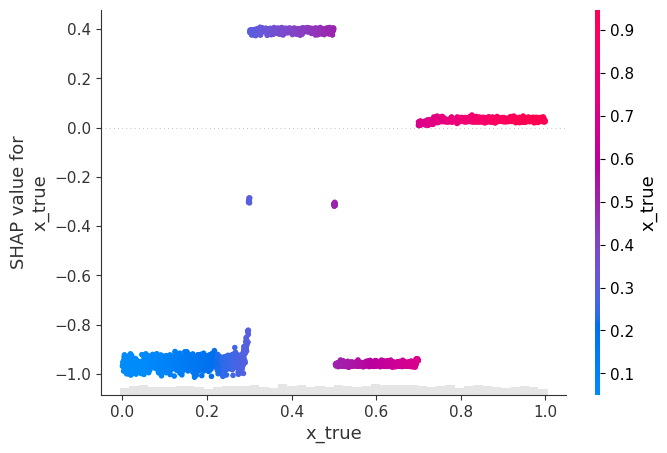

In [12]:
# Partial Dependence Plot of how x_true acts on variance
xgblss_best_est._BoosterLSS.plot(
    X_test,
    parameter="scale",
    feature="x_true",
    plot_type="Partial_Dependence"
)

[23:10:21] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


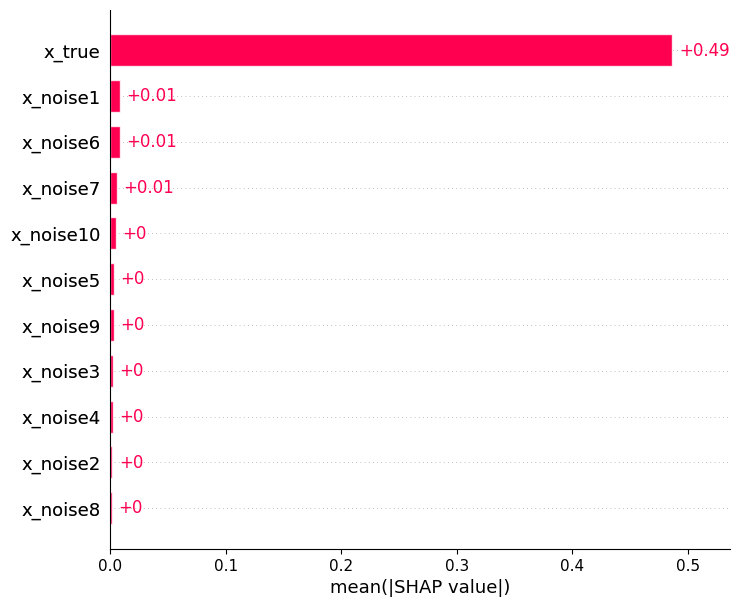

In [13]:
# Feature Importance of scale parameter
xgblss._BoosterLSS.plot(
    X_test,
    parameter="scale",
    plot_type="Feature_Importance"
)